<a href="https://colab.research.google.com/github/cdtlaura/nlp2/blob/main/introduction_to_data_processing_ii_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

URL = 'https://raw.githubusercontent.com/cdtlaura/nlp2/refs/heads/main/n_movies.csv'
df = pd.read_csv(URL)
df.head()

,title,year,certificate,duration,genre,rating,description,stars,votes
0,Cobra Kai,(2018– ),TV-14,30 min,"Action, Comedy, Drama",8.5,Decades after their 1984 All Valley Karate Tou...,"['Ralph Macchio, ', 'William Zabka, ', 'Courtn...","177,031"
1,The Crown,(2016– ),TV-MA,58 min,"Biography, Drama, History",8.7,Follows the political rivalries and romance of...,"['Claire Foy, ', 'Olivia Colman, ', 'Imelda St...","199,885"
2,Better Call Saul,(2015–2022),TV-MA,46 min,"Crime, Drama",8.9,The trials and tribulations of criminal lawyer...,"['Bob Odenkirk, ', 'Rhea Seehorn, ', 'Jonathan...","501,384"
3,Devil in Ohio,(2022),TV-MA,356 min,"Drama, Horror, Mystery",5.9,When a psychiatrist shelters a mysterious cult...,"['Emily Deschanel, ', 'Sam Jaeger, ', 'Gerardo...","9,773"
4,Cyberpunk: Edgerunners,(2022– ),TV-MA,24 min,"Animation, Action, Adventure",8.6,A Street Kid trying to survive in a technology...,"['Zach Aguilar, ', 'Kenichiro Ohashi, ', 'Emi ...","15,413"


/content/drive/MyDrive/Reviews.csv

In [ ]:
# Fill missing values in 'overview' with an empty string
df['description'] = df['description'].fillna('')

# Display the first 5 rows of the 'overview' column
df['description'].head()


,description
0,Decades after their 1984 All Valley Karate Tou...
1,Follows the political rivalries and romance of...
2,The trials and tribulations of criminal lawyer...
3,When a psychiatrist shelters a mysterious cult...
4,A Street Kid trying to survive in a technology...


In [ ]:
# MORE ADVANCED Preprocessing SO RUN THIS CEL OR THE NEXT BUT NOT BOTH!
# Import necessary libraries for text preprocessing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Download necessary NLTK data files (only need to run once)
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Define a text preprocessing function
def preprocess_text(text):
    # Convert to string if it's not already
    if not isinstance(text, str):
        text = str(text)

    # 1. Lowercase the text
    text = text.lower()

    # 2. Tokenize the text
    tokens = word_tokenize(text)

    # 3. Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word.isalnum() and word not in stop_words]

    # 4. Lemmatize the tokens
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return tokens

# Ensure all values in 'overview' are strings
df['tokenized_description'] = df['description'].astype(str)

# Apply the text preprocessing function directly to the 'overview' column
df['tokenized_description'] = df['tokenized_description'].apply(preprocess_text)

# Display the first 5 rows of the 'overview' column after preprocessing
df['tokenized_description'].head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


,tokenized_description
0,"[decade, 1984, valley, karate, tournament, bou..."
1,"[follows, political, rivalry, romance, queen, ..."
2,"[trial, tribulation, criminal, lawyer, jimmy, ..."
3,"[psychiatrist, shelter, mysterious, cult, esca..."
4,"[street, kid, trying, survive, technology, bod..."


In [ ]:
# Create a Word2Vec model
model = Word2Vec(sentences=df['tokenized_description'], vector_size=100, window=5, min_count=1, workers=4)

# Display the vocabulary size
print(f"Vocabulary size: {len(model.wv.index_to_key)}")

Vocabulary size: 19637


In [ ]:
# Function to generate an embedding for each movie overview
def get_movie_embedding(tokenized_text, model, embedding_size=100):
    # Get word embeddings for each word in the tokenized text
    valid_embeddings = [model.wv[word] for word in tokenized_text if word in model.wv]

    # If no valid embeddings, return a zero vector of the same size as the word vectors
    if len(valid_embeddings) == 0:
        return np.zeros(embedding_size)

    # Otherwise, return the mean of the valid embeddings
    return np.mean(valid_embeddings, axis=0)

# Apply the function to generate embeddings for each movie
# Make sure to define the embedding size to match the model's vector size
embedding_size = model.vector_size
df['review_embedding'] = df['tokenized_description'].apply(lambda x: get_movie_embedding(x, model, embedding_size=embedding_size))


In [ ]:
# Check for invalid embeddings (e.g., NaNs or wrong shapes)
invalid_embeddings = df['review_embedding'].apply(lambda x: x.shape[0] != embedding_size or np.any(np.isnan(x)))

# Print the number of invalid embeddings
print(f"Number of invalid embeddings: {invalid_embeddings.sum()}")

# Filter out invalid embeddings, if any
df = df[~invalid_embeddings]

Number of invalid embeddings: 0


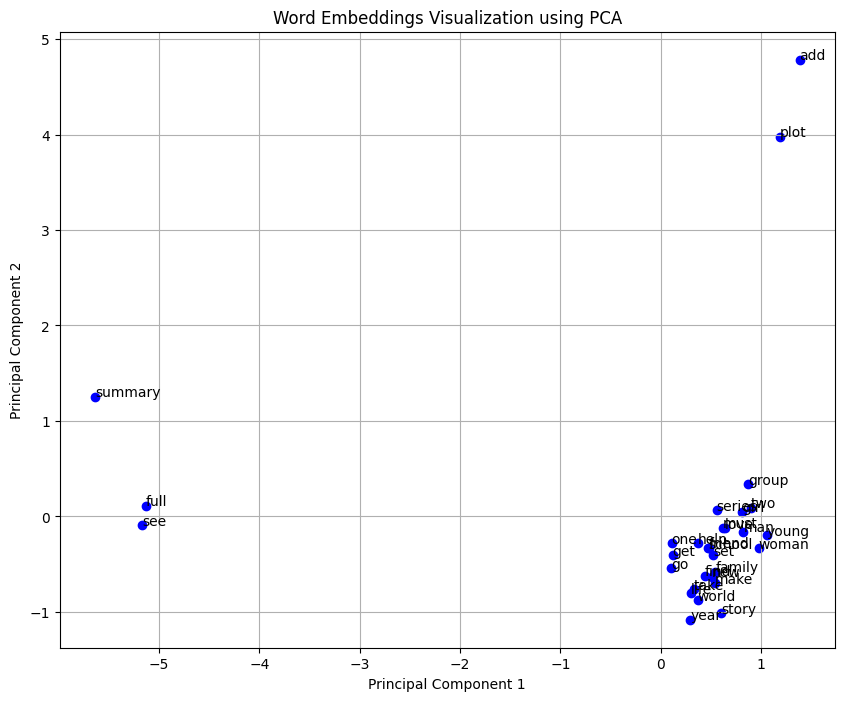

In [ ]:
# Import necessary libraries for visualization
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Select 30 random words from the vocabulary
words = list(model.wv.index_to_key)[:30]

# Get the word embeddings for these words
word_vectors = [model.wv[word] for word in words]

# Use PCA to reduce the word vectors to 2 dimensions
pca = PCA(n_components=2)
word_vectors_pca = pca.fit_transform(word_vectors)

# Create a scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(word_vectors_pca[:, 0], word_vectors_pca[:, 1], c='blue')

# Annotate each point with the word
for i, word in enumerate(words):
    plt.annotate(word, xy=(word_vectors_pca[i, 0], word_vectors_pca[i, 1]))

# Display the plot
plt.title("Word Embeddings Visualization using PCA")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid()
plt.show()

In [ ]:
# Calculate cosine similarity between movie embeddings
embeddings_matrix = np.vstack(df['review_embedding'].values)
cosine_sim = cosine_similarity(embeddings_matrix)

# Display the shape of the similarity matrix
print(f"Cosine similarity matrix shape: {cosine_sim.shape}")

Cosine similarity matrix shape: (9957, 9957)


In [ ]:
# Calculate cosine similarity between movie embeddings
embeddings_matrix = np.vstack(df['review_embedding'].values)
cosine_sim = cosine_similarity(embeddings_matrix)

# Create a DataFrame for the cosine similarity matrix
cosine_sim_df = pd.DataFrame(cosine_sim, index=df['title'], columns=df['title'])

# Display the first 30 movies and their similarities
cosine_sim_df_subset = cosine_sim_df.iloc[:30, :30]
cosine_sim_df_subset.head()


title,Cobra Kai,The Crown,Better Call Saul,Devil in Ohio,Cyberpunk: Edgerunners,The Sandman,Rick and Morty,Breaking Bad,The Imperfects,Blonde,...,The Lord of the Rings: The Fellowship of the Ring,Grey's Anatomy,Supernatural,American Horror Story,The Accidental Narco,NCIS,Friends,Shameless,Modern Family,Ozark
title,,,,,,,,,,,,,,,,,,,,,
Cobra Kai,1.000000,0.999503,0.999709,0.999756,0.999896,0.999804,0.999529,0.998869,0.999917,0.999470,...,0.999902,0.999637,0.999909,0.999844,0.999713,0.999551,0.999659,0.999837,0.999839,0.999901
The Crown,0.999503,1.000000,0.999655,0.999714,0.999613,0.999820,0.999802,0.998607,0.999597,0.998603,...,0.999596,0.999733,0.999617,0.999802,0.999869,0.999887,0.999563,0.999549,0.999502,0.999554
Better Call Saul,0.999709,0.999655,1.000000,0.999632,0.999868,0.999787,0.999474,0.998714,0.999828,0.999072,...,0.999793,0.999498,0.999855,0.999840,0.999834,0.999759,0.999426,0.999668,0.999641,0.999808
Devil in Ohio,0.999756,0.999714,0.999632,1.000000,0.999756,0.999849,0.999811,0.998974,0.999818,0.999337,...,0.999846,0.999906,0.999819,0.999871,0.999769,0.999691,0.999900,0.999874,0.999900,0.999786
Cyberpunk: Edgerunners,0.999896,0.999613,0.999868,0.999756,1.000000,0.999871,0.999536,0.998881,0.999952,0.999327,...,0.999918,0.999620,0.999954,0.999904,0.999839,0.999707,0.999592,0.999834,0.999798,0.999943


In [ ]:
# Create a mapping from movie title to index
review_indices = pd.Series(df.index, index=df['title']).drop_duplicates()

# Function to recommend movies based on cosine similarity
def recommend_movies(title, cosine_sim=cosine_sim, df=df, movie_indices=review_indices):
    """Recommends movies based on cosine similarity.

    Args:
        title (str): Title of the movie to find recommendations for.
        cosine_sim (np.ndarray): Cosine similarity matrix.
        df (pd.DataFrame): DataFrame containing movie data.
        movie_indices (pd.Series): Mapping from movie title to index.

    Returns:
        pd.Series: Titles of recommended movies.
    """
    # Get the index of the movie that matches the title
    idx = movie_indices[title]

    # Get the pairwise similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on similarity scores
    # Fix: Use the first element of the similarity score (assuming it's a single value or the desired representative)
    sim_scores = sorted(sim_scores, key=lambda x: x[1][0] if isinstance(x[1], (np.ndarray, list)) else x[1], reverse=True)

    # Get the indices of the 10 most similar movies
    sim_scores = sim_scores[1:11]

    # Get the movie indices
    movie_indices_rec = [i[0] for i in sim_scores] # Changed variable name to avoid shadowing

    # Return the top 10 most similar movies
    return df['title'].iloc[movie_indices_rec] # Use the variable with recommendations

# Example: Recommend movies similar to 'Avatar'
recommendations = recommend_movies('Cobra Kai')
print(recommendations)

8             The Imperfects
4     Cyberpunk: Edgerunners
7               Breaking Bad
3              Devil in Ohio
5                The Sandman
6             Rick and Morty
1                  The Crown
2           Better Call Saul
10           Stranger Things
9                     Blonde
Name: title, dtype: object


In [ ]:
# Function to recommend movies based on cosine similarity
def recommend_movies_with_scores(title, cosine_sim=cosine_sim, df=df, movie_indices=review_indices):
    # Get the index of the movie that matches the title
    idx = movie_indices[title]

    # Get the pairwise similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on similarity scores
    # Fix: Use the first element of the similarity score to sort
    sim_scores = sorted(sim_scores, key=lambda x: x[1][0], reverse=True)

    # Get the indices and similarity scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]  # Skip the first item since it's the movie itself

    # Get the movie indices and similarity scores separately
    movie_indices = [i[0] for i in sim_scores]
    similarity_scores = [i[1] for i in sim_scores]

    # Create a DataFrame with movie titles and their similarity scores
    recommendations_df = pd.DataFrame({
        'Movie Title': df['title'].iloc[movie_indices].values,
        'Similarity Score': similarity_scores
    })

    return recommendations_df

# Example: Recommend movies similar to 'Avatar' and print titles with scores
recommendations_with_scores = recommend_movies_with_scores('Cobra Kai')
print(recommendations_with_scores)

              Movie Title                                   Similarity Score
0          The Imperfects  [0.99992067, 0.99951166, 0.999769, 0.9998056, ...
1  Cyberpunk: Edgerunners  [0.999911, 0.99950206, 0.99979645, 0.9997743, ...
2            Breaking Bad  [0.99990505, 0.99948466, 0.9997295, 0.9997953,...
3           Devil in Ohio  [0.9998866, 0.99970615, 0.99978185, 0.99988544...
4             The Sandman  [0.9998738, 0.99961466, 0.99976534, 0.99988145...
5          Rick and Morty  [0.9998726, 0.9994011, 0.9998104, 0.99959207, ...
6               The Crown  [0.9998426, 0.9997583, 0.9997117, 0.99992716, ...
7        Better Call Saul  [0.99980444, 0.99980927, 0.9998136, 0.9997916,...
8         Stranger Things  [0.9997624, 0.9998198, 0.9997125, 0.9999138, 0...
9                  Blonde  [0.999649, 0.9997773, 0.99954516, 0.9998881, 0...


Aha!:
I learned new techniques like using embeddings and dimensionality reduction methods (PCA) to visualize high-dimensional data. This enhanced my understanding of working with complex datasets efficiently.

Huh?:
The most challenging part was handling memory overloads in Colab, especially when dealing with large datasets and ensuring the environment didn’t crash.

Cool!:
I enjoyed visualizing the data embeddings, seeing how words are distributed in lower-dimensional space, and understanding relationships between terms.

Gotcha!:
I initially underestimated the complexity of cosine similarity calculations across embeddings, but I now realize how crucial proper memory management is.

Summary:
The key takeaways are effective memory management, using embeddings for text data, and applying PCA for visualization. These skills will be useful in future machine learning and natural language processing projects.